# EDA

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def optimize_memory(df):
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type == 'int64':
            df[col] = df[col].astype('int32')
        elif col_type == 'float64':
            df[col] = df[col].astype('float32')
        elif col_type == 'object':  # For string-based data
            df[col] = df[col].astype('category')
    return df

chunks = []
train_dataset = r"E:\Projects\guvi\train.csv"
# chunking of dataset and process each chunk
for chunk in pd.read_csv(train_dataset, chunksize=500000,low_memory=False):
    chunk = optimize_memory(chunk)
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)

del chunks
df.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,1.709400e+12,26,18583,687462,2024-06-06T05:56:47.000Z,31,813,Malware,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,Suspicious,Malicious,242,1445,10630
1,9.277130e+11,33,5065,3990,2024-06-03T10:45:09.000Z,38,25,Impact,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1.090920e+12,201,150787,807590,2024-06-13T03:36:40.000Z,419,444,Execution,T1047;T1059;T1053;T1569;T1059.001;T1053.002;T1...,BenignPositive,...,NaN,Destination,5,66,NaN,NaN,NaN,242,1445,10630
3,1.434520e+12,204,108287,28575,2024-06-08T16:54:57.000Z,44,1233,SuspiciousActivity,NaN,TruePositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,1.005020e+12,54,528202,1458226,2024-06-09T02:48:01.000Z,102,58829,Exfiltration,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [55]:
df.shape

(1048575, 45)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 45 columns):
 #   Column              Non-Null Count    Dtype   
---  ------              --------------    -----   
 0   Id                  1048575 non-null  float32 
 1   OrgId               1048575 non-null  int32   
 2   IncidentId          1048575 non-null  int32   
 3   AlertId             1048575 non-null  int32   
 4   Timestamp           1048575 non-null  object  
 5   DetectorId          1048575 non-null  int32   
 6   AlertTitle          1048575 non-null  int32   
 7   Category            1048575 non-null  object  
 8   MitreTechniques     446210 non-null   object  
 9   IncidentGrade       1042860 non-null  category
 10  ActionGrouped       6254 non-null     object  
 11  ActionGranular      6254 non-null     object  
 12  EntityType          1048575 non-null  object  
 13  EvidenceRole        1048575 non-null  category
 14  DeviceId            1048575 non-null  int32   
 15

In [57]:
df.isnull().sum()

Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
Timestamp                   0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques        602365
IncidentGrade            5715
ActionGrouped         1042321
ActionGranular        1042321
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
EmailClusterId        1037947
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
ThreatFamily          1040479
FileName                    0
FolderPath

In [58]:
duplicate_count = df.duplicated().sum()
duplicate_count 

397

In [59]:
df['IncidentGrade'].value_counts()

IncidentGrade
BenignPositive    451615
TruePositive      366625
FalsePositive     224620
Name: count, dtype: int64

# Data preprocessing for Training

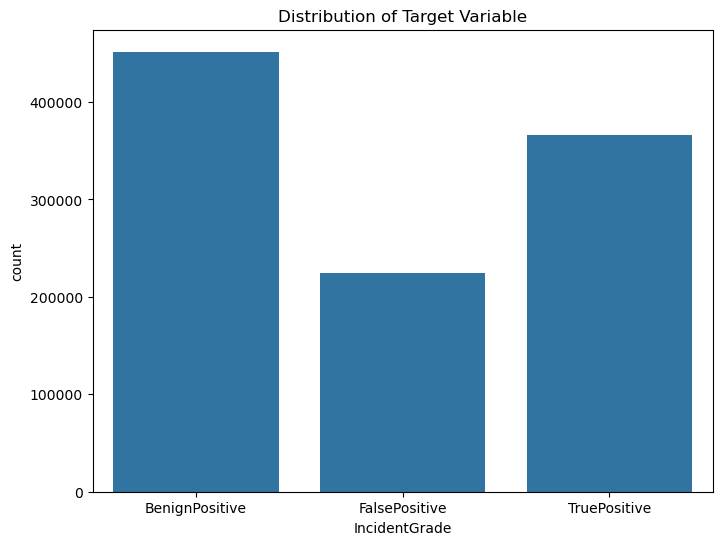

In [60]:
# plot Distribution of Target Variable
plt.figure(figsize=(8, 6))
sns.countplot(x=df['IncidentGrade'])
plt.title('Distribution of Target Variable')
plt.show()

In [61]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# percentage of missing values for each column
missing_percentage = df.isnull().sum() / len(df) * 100

# columns with more than 50% missing values
columns_to_drop = missing_percentage[missing_percentage > 50].index
print("Columns with more than 50% missing values are dropped")

df.drop(columns=columns_to_drop, axis=1, inplace=True)

Columns with more than 50% missing values are dropped


In [62]:
# missing values for categorical columns
categorical_columns = df.select_dtypes(include=['object','category']).columns
for col in categorical_columns:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)
        print(f"Imputed categorical column '{col}' with mode value: {mode_val}")

Imputed categorical column 'IncidentGrade' with mode value: BenignPositive


In [63]:
# missing values for numeric columns
numeric_columns = df.select_dtypes(include=['int32','float32']).columns
for col in numeric_columns:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Imputed numeric column '{col}' with median value: {median_val}")

In [64]:
def outliers(df, iqr_multiplier=1.5):
    numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64', 'float64'])
    for col in numeric_features.columns:
        if df[col].nunique() > 10:
            Q1 = numeric_features[col].quantile(0.25)
            Q3 = numeric_features[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_multiplier * IQR
            upper_bound = Q3 + iqr_multiplier * IQR   
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df = outliers(df, iqr_multiplier=1.5) 

In [65]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Hour'] = df['Timestamp'].dt.hour


df.drop(columns=['Timestamp'], inplace=True)

In [66]:
id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256', 
              'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 
              'DeviceName', 'NetworkMessageId',  'RegistryKey', 'RegistryValueName', 
              'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 
              'FileName', 'FolderPath', 'ResourceIdName','OSFamily', 'OSVersion', 'City','CountryCode', 'State']

numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).drop(columns=id_columns, errors='ignore')

# Scaling numerical features 
scaler = MinMaxScaler()
df[numeric_features.columns] = scaler.fit_transform(numeric_features)

In [67]:
# categorical columns
label_encoder = LabelEncoder()
categorical_columns = ['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole']

for col in categorical_columns:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))  # Convert to string if necessary

In [68]:
df.drop_duplicates(inplace=True)

In [69]:
path = r"E:\Projects\guvi\trained.csv"
df.to_csv(path, index=False)
print("Data preprocessing complete and saved.")

Data preprocessing complete and saved.


# EDA for Test Dataset

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def optimize_memory(df_1):
    # Downcast numerical columns
    for col in df_1.columns:
        col_type = df_1[col].dtypes
        if col_type == 'int64':
            df_1[col] = df_1[col].astype('int32')
        elif col_type == 'float64':
            df_1[col] = df_1[col].astype('float32')
        elif col_type == 'object':  # For string-based data
            df_1[col] = df_1[col].astype('category')
    return df_1

chunks = []
test_dataset = r"E:\Projects\guvi\test.csv"
for chunk in pd.read_csv(test_dataset, chunksize=500000,low_memory=False):
    chunk = optimize_memory(chunk)
    chunks.append(chunk)

df_1 = pd.concat(chunks, ignore_index=True)

del chunks

df_1.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City,Usage
0,3390,657,11767,87199,2024-06-04T22:56:27.000Z,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Private
1,3658,3,91158,632273,2024-06-03T12:58:26.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,0,0,NaN,Suspicious,Suspicious,242,1445,10630,Public
2,1715,145,32247,131719,2024-06-08T03:20:49.000Z,2932,10807,LateralMovement,T1021;T1027.002;T1027.005;T1105,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Public
3,5148,222,15294,917686,2024-06-12T12:07:31.000Z,0,0,InitialAccess,T1078;T1078.004,FalsePositive,...,NaN,5,66,NaN,NaN,NaN,242,1445,10630,Public
4,5019,363,7615,5944,2024-06-06T17:42:05.000Z,27,18,Discovery,T1087;T1087.002,BenignPositive,...,Suspicious,5,66,NaN,NaN,NaN,242,1445,10630,Public



Shape of the dataset: (4147992, 46)
Column Names in the Dataset:
Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId',
       'AlertTitle', 'Category', 'MitreTechniques', 'IncidentGrade',
       'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'EmailClusterId', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'ThreatFamily', 'FileName', 'FolderPath',
       'ResourceIdName', 'ResourceType', 'Roles', 'OSFamily', 'OSVersion',
       'AntispamDirection', 'SuspicionLevel', 'LastVerdict', 'CountryCode',
       'State', 'City', 'Usage'],
      dtype='object')

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4147992 entries, 0 to 4147991
Data columns (total 46 columns):
 #   Column              Dtyp

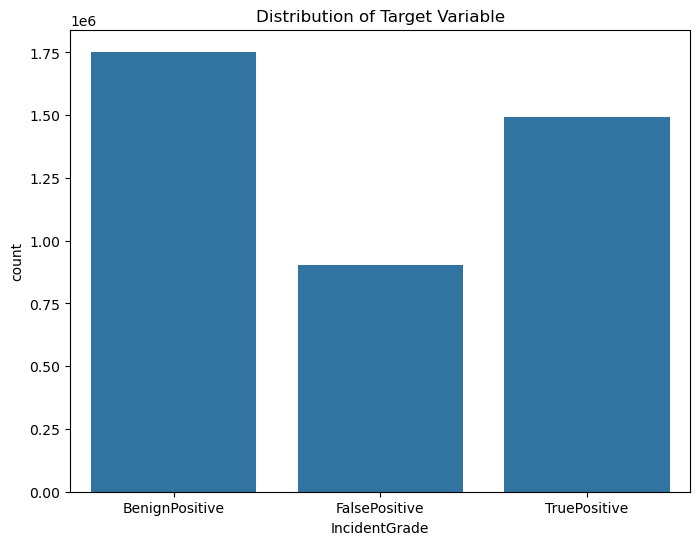

In [71]:
print("\nShape of the dataset:", df_1.shape)

print("Column Names in the Dataset:")
print(df_1.columns)

print("\nDataset Information:")
print(df_1.info())

print("\nMissing values:")
print(df_1.isnull().sum())

duplicate_count = df_1.duplicated().sum()
print("\nNumber of duplicate rows in the dataset:", duplicate_count)

print("\nTarget variable distribution:")
print(df_1['IncidentGrade'].value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(x=df_1['IncidentGrade'])
plt.title('Distribution of Target Variable')
plt.show()

# Data Preprocessing for Test Dataset

In [72]:
# percentage of missing values for each column
missing_percentage = df_1.isnull().sum() / len(df_1) * 100

# columns with more than 50% missing values
columns_to_drop = missing_percentage[missing_percentage > 50].index
print("Columns with more than 50% missing values are dropped:")
print(columns_to_drop)

df_1.drop(columns=columns_to_drop, axis=1, inplace=True)

# missing values for numeric columns
numeric_columns = df_1.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).columns
for col in numeric_columns:
    if df_1[col].isnull().any():
        median_val = df_1[col].median()
        df_1[col] = df_1[col].fillna(median_val)
        print(f"Imputed numeric column '{col}' with median value: {median_val}")

# missing values for categorical columns
categorical_columns = df_1.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if df_1[col].isnull().any():
        mode_val = df_1[col].mode()[0]
        df_1[col] = df_1[col].fillna(mode_val)
        print(f"Imputed categorical column '{col}' with mode value: {mode_val}")

def outliers(df_1, iqr_multiplier=1.5):
    numeric_features = df_1.select_dtypes(include=['int32', 'int16', 'float32', 'int64', 'float64'])
    for col in numeric_features.columns:
        Q1 = numeric_features[col].quantile(0.25)
        Q3 = numeric_features[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR
            
        df_1 = df_1[(df_1[col] >= lower_bound) & (df_1[col] <= upper_bound)]
    return df_1

df_1 = outliers(df_1, iqr_multiplier=1.5)  # Adjusting the IQR multiplier if necessary

df_1['Timestamp'] = pd.to_datetime(df_1['Timestamp'], errors='coerce')
df_1['Year'] = df_1['Timestamp'].dt.year
df_1['Month'] = df_1['Timestamp'].dt.month
df_1['DayOfWeek'] = df_1['Timestamp'].dt.dayofweek
df_1['Hour'] = df_1['Timestamp'].dt.hour

df_1.drop(columns=['Timestamp','Usage'], inplace=True)

id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256', 
              'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 
              'DeviceName', 'NetworkMessageId',  'RegistryKey', 'RegistryValueName', 
              'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 
              'FileName', 'FolderPath', 'ResourceIdName','OSFamily','OSVersion', 'City','CountryCode', 'State']

numeric_features = df_1.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).drop(columns=id_columns, errors='ignore')

scaler = MinMaxScaler()
df_1[numeric_features.columns] = scaler.fit_transform(numeric_features)

label_encoder = LabelEncoder()
categorical_columns = ['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole']

for col in categorical_columns:
    if col in df_1.columns:
        df_1[col] = label_encoder.fit_transform(df_1[col].astype(str)) 

df_1.drop_duplicates(inplace=True)

path = r"E:\Projects\guvi\tested.csv"
df_1.to_csv(path, index=False)
print("Data preprocessing complete and saved .")

Columns with more than 50% missing values are dropped:
Index(['MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId',
       'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection',
       'SuspicionLevel', 'LastVerdict'],
      dtype='object')
Data preprocessing complete and saved .


# Logistic Regression (BASE MODEL)

In [73]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

df = pd.read_csv(r"E:\Projects\guvi\trained.csv")

X = df.drop('IncidentGrade', axis=1)  
y = df['IncidentGrade']  

# training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

logreg = LogisticRegression(C = 100, penalty = 'l1', solver='liblinear')

logreg = logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_val)

print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.73      0.66      2211
           1       0.83      0.44      0.57      1721
           2       0.92      0.95      0.94     14533

    accuracy                           0.87     18465
   macro avg       0.79      0.71      0.72     18465
weighted avg       0.88      0.87      0.87     18465

Confusion Matrix:
[[ 1615   100   496]
 [  335   751   635]
 [  699    52 13782]]


C:\Users\Mayank\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# Decision Tree 

In [74]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint

df = pd.read_csv(r"E:\Projects\guvi\trained.csv")

X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

dtree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth= 20, min_samples_split=4, min_samples_leaf=1, 
                               max_features= 'log2', random_state=42)

dtree = dtree.fit(X_train,y_train)

y_pred = dtree.predict(X_val)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79      2211
           1       0.84      0.79      0.81      1721
           2       0.98      0.96      0.97     14533

    accuracy                           0.93     18465
   macro avg       0.85      0.87      0.86     18465
weighted avg       0.94      0.93      0.93     18465

Confusion Matrix:
[[ 1884   149   178]
 [  226  1364   131]
 [  431   117 13985]]


# Random Forest Classifier (BEST MODEL)

In [75]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import randint

df = pd.read_csv(r"E:\Projects\guvi\trained.csv")

X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# training and validation sets 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators = 200, min_samples_split = 2, min_samples_leaf = 1, max_features = None, max_depth = 30, 
                            bootstrap = True, random_state=42)

rf = rf.fit(X_train,y_train)
y_pred = rf.predict(X_val)

# Print results
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2211
           1       0.93      0.93      0.93      1721
           2       0.99      0.99      0.99     14533

    accuracy                           0.98     18465
   macro avg       0.96      0.96      0.96     18465
weighted avg       0.98      0.98      0.98     18465

Confusion Matrix:
[[ 2121    67    23]
 [   54  1599    68]
 [   54    46 14433]]


# XGBoost

In [76]:
! pip install xgboost

In [77]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from functools import partial

df = pd.read_csv(r"E:\Projects\guvi\trained.csv")

X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# training and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

xgb = xgb.XGBClassifier(subsample = 0.8, n_estimators = 200, max_depth = 9, learning_rate = 0.2, colsample_bytree = 1.0,
                        random_state=42, use_label_encoder=False, eval_metric='logloss')

xgb = xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_val)

print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

C:\Users\Mayank\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:11:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2211
           1       0.93      0.92      0.92      1721
           2       0.99      0.99      0.99     14533

    accuracy                           0.98     18465
   macro avg       0.95      0.95      0.95     18465
weighted avg       0.98      0.98      0.98     18465

Confusion Matrix:
[[ 2087    73    51]
 [   70  1581    70]
 [  108    45 14380]]


# Best Model 

In [78]:
import pandas as pd

report = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy':[0.91,0.98,0.99,0.99],
    'Macro-F1 Score':[ 0.76, 0.93, 0.98, 0.98],
    'Precision': [0.80,0.92,0.98,0.98],
    'Recall': [0.73,0.94,0.98 ,0.98]

}

df = pd.DataFrame(report)

# comparison table
print("Comparison Table:")
print(df.to_string(index=False))

best_model = df.loc[df['Macro-F1 Score'].idxmax()]

print("\nBest Model Based on Macro-F1 Score:")
print(best_model)

Comparison Table:
              Model  Accuracy  Macro-F1 Score  Precision  Recall
Logistic Regression      0.91            0.76       0.80    0.73
      Decision Tree      0.98            0.93       0.92    0.94
      Random Forest      0.99            0.98       0.98    0.98
            XGBoost      0.99            0.98       0.98    0.98

Best Model Based on Macro-F1 Score:
Model             Random Forest
Accuracy                   0.99
Macro-F1 Score             0.98
Precision                  0.98
Recall                     0.98
Name: 2, dtype: object


# Feature Importance 

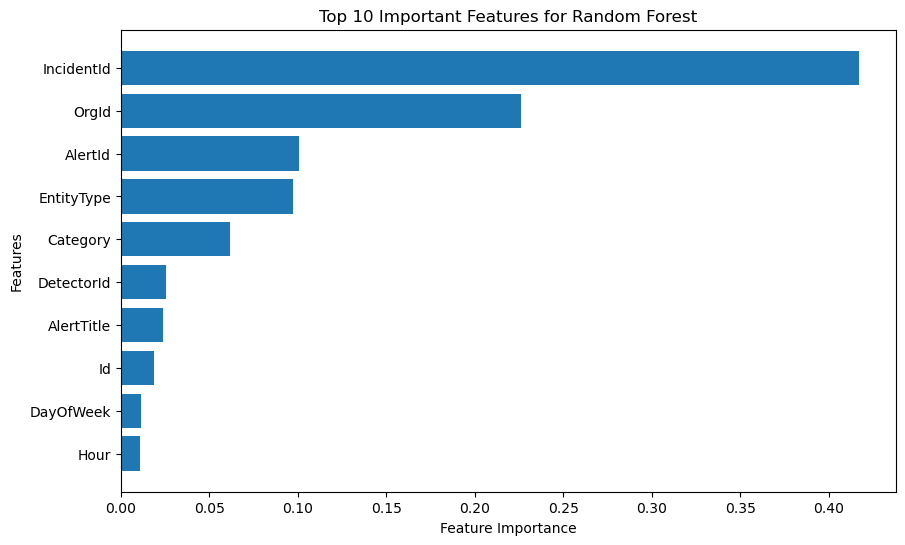

                 Id  OrgId  IncidentId  AlertId  DetectorId  AlertTitle  \
51702  1.005020e+12    367       53309   978701           0    0.000000   
13748  4.896260e+11    216       48262   137735           1    0.002278   
30786  1.443110e+12     38      131103    41315           1    0.002278   
63917  4.209070e+11    229      145666   241782           1    0.002278   
72089  9.448930e+11    341       47188    95475           6    0.011390   

       Category  EntityType  EvidenceRole  DeviceId  ...  ResourceIdName  \
51702         5           0             1     98799  ...            3586   
13748         5           4             1     98799  ...            3586   
30786         5           4             1     98799  ...            3586   
63917         5           4             1     98799  ...            3586   
72089         5           4             1     98799  ...            3586   

       OSFamily  OSVersion  CountryCode  State   City  Year     Month  \
51702         5    

In [79]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# feature importances from the best Random Forest model
importances = rf.feature_importances_

features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Important Features for Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()

misclassified_idx = (y_val != y_pred)

misclassified_samples = X_val[misclassified_idx].copy()

print(misclassified_samples.head(5))

print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# Saving the Best Model

In [80]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from joblib import dump
from imblearn.pipeline import Pipeline
from scipy.stats import randint

df = pd.read_csv(r"E:\Projects\guvi\trained.csv")

X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# training and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)

rf = RandomForestClassifier(n_estimators = 200, min_samples_split = 2, min_samples_leaf = 1, max_features = None, max_depth = 30, 
                            bootstrap = True, random_state=42)

pipeline = Pipeline(steps=[
    ('smote', smote),
    ('classifier', rf)
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)

print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

model_path = r"E:\Projects\guvi\Model.pkl"
dump(rf, model_path)
print(f"Model saved to {model_path}")

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      2211
           1       0.88      0.91      0.90      1721
           2       1.00      0.98      0.99     14533

    accuracy                           0.96     18465
   macro avg       0.91      0.94      0.92     18465
weighted avg       0.97      0.96      0.97     18465

Confusion Matrix:
[[ 2072   116    23]
 [  111  1565    45]
 [  273    89 14171]]
Model saved to E:\Projects\guvi\Model.pkl


# Evaluation of Random Forest Model on Test Data

In [81]:
import pandas as pd
from joblib import load
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score


In [82]:
model_path = r"E:\Projects\guvi\Model.pkl"
best_rf = load(model_path)

test_data_path = r"E:\Projects\guvi\tested.csv"
test_df = pd.read_csv(test_data_path)

# Separate features and target from test data
X_test = test_df.drop('IncidentGrade', axis=1)  
y_test = test_df['IncidentGrade']

In [83]:
y_test_pred = best_rf.predict(X_test)

In [84]:
print("\nClassification Report on Test Data:")
report = classification_report(y_test, y_test_pred, output_dict=True)
print(classification_report(y_test, y_test_pred))

macro_f1 = report['macro avg']['f1-score']
macro_precision = report['macro avg']['precision']
macro_recall = report['macro avg']['recall']

print("\nMacro-F1 Score: {:.2f}".format(macro_f1))
print("Macro Precision: {:.2f}".format(macro_precision))
print("Macro Recall: {:.2f}".format(macro_recall))

# Confusion Matrix
print("\nConfusion Matrix on Test Data:")
print(confusion_matrix(y_test, y_test_pred))


Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.63      0.84      0.72     24124
           1       0.61      0.69      0.65     21252
           2       0.99      0.96      0.97    303765

    accuracy                           0.93    349141
   macro avg       0.75      0.83      0.78    349141
weighted avg       0.94      0.93      0.94    349141


Macro-F1 Score: 0.78
Macro Precision: 0.75
Macro Recall: 0.83

Confusion Matrix on Test Data:
[[ 20345   2949    830]
 [  4753  14669   1830]
 [  6978   6416 290371]]
